In [2]:
import pandas as pd 
from datasets import load_from_disk
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
df = load_from_disk("analytics")

In [3]:
def get_length(ex):
    ex["Length"] = len(tokenizer(ex["article"])["input_ids"])
    return ex

df = df.map(get_length, num_proc=8)

In [4]:
from tqdm.auto import tqdm

collect_df = {"ID" : [],
             "Layer_Cut" : [],
             "Sequence_Length" : [],
             "Logits" : [],
             "Tokens" : [],
             "Length" : [],
             "text_size" : []}

i = 0
for element in tqdm(df):
    for col in [v for v in element.keys() if "_" in v]:
        collect_df["ID"].append(i)
    
        sl, lc = col.split("_")
        
        collect_df["Layer_Cut"].append(lc)
        collect_df["Sequence_Length"].append(sl)
        collect_df["Logits"].append(element[col]["top_5_l"])
        collect_df["Tokens"].append(element[col]["top_5_i"])
        collect_df["Length"].append(element[col]["length"])
        collect_df["text_size"].append(element["Length"])
    i+=1

  0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(collect_df)
df["Sequence_Length"] = df["Sequence_Length"].astype(int)
df["Layer_Cut"] = df["Layer_Cut"].astype(int)
df.to_json("analytics_slerp.json")

In [6]:
df = df[df["text_size"] > df["Sequence_Length"]].drop("text_size", axis = 1).reset_index(drop = True)

<Axes: xlabel='Layer_Cut', ylabel='Acc'>

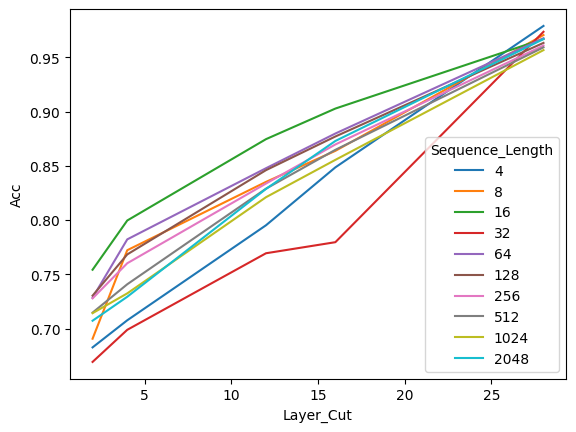

In [7]:
import seaborn as sns

df_gs = df[df["Layer_Cut"] == 40]
df_compare = df[df["Layer_Cut"] != 40]

df_gs = df_gs[["ID", "Sequence_Length", "Tokens"]]
df_gs["Tokens"] = [v[0] for v in df_gs["Tokens"]]

df_compare = df_compare[["ID", "Layer_Cut", "Sequence_Length", "Tokens"]]
df_compare["Tokens"] = [v[0] for v in df_compare["Tokens"]]

acc_check = pd.merge(df_compare, df_gs, on = ["ID", "Sequence_Length"], suffixes=["_bench", "_true"])
acc_check["Acc"] = acc_check["Tokens_bench"] == acc_check["Tokens_true"]
acc_check["Acc"] = acc_check["Acc"].astype(int)

to_plot_acc = acc_check.drop(["Tokens_bench", "Tokens_true", "ID"], axis = 1).groupby(["Layer_Cut", "Sequence_Length"]).mean().reset_index()
to_plot_acc["Sequence_Length"] = to_plot_acc["Sequence_Length"].astype(str)

sns.lineplot(data=to_plot_acc, x="Layer_Cut", y = "Acc", hue = "Sequence_Length")

<Axes: xlabel='Layer_Cut', ylabel='Acc'>

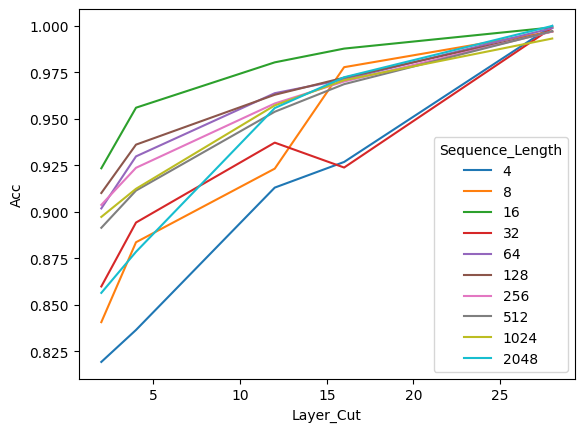

In [8]:
df_gs = df[df["Layer_Cut"] == 40]
df_compare = df[df["Layer_Cut"] != 40]

df_gs = df_gs[["ID", "Sequence_Length", "Tokens"]]
df_gs["Tokens"] = [v[0] for v in df_gs["Tokens"]]

df_compare = df_compare[["ID", "Layer_Cut", "Sequence_Length", "Tokens"]]
df_compare["Tokens"] = [v[:3] for v in df_compare["Tokens"]]

acc_check = pd.merge(df_compare, df_gs, on = ["ID", "Sequence_Length"], suffixes=["_bench", "_true"])
acc_check["Acc"] = [acc_check["Tokens_true"][i] in acc_check["Tokens_bench"][i] for i in range(acc_check.shape[0])]
acc_check["Acc"] = acc_check["Acc"].astype(int)

to_plot_acc = acc_check.drop(["Tokens_bench", "Tokens_true", "ID"], axis = 1).groupby(["Layer_Cut", "Sequence_Length"]).mean().reset_index()
to_plot_acc["Sequence_Length"] = to_plot_acc["Sequence_Length"].astype(str)

sns.lineplot(data=to_plot_acc, x="Layer_Cut", y = "Acc", hue = "Sequence_Length")

<Axes: xlabel='Layer_Cut', ylabel='Acc'>

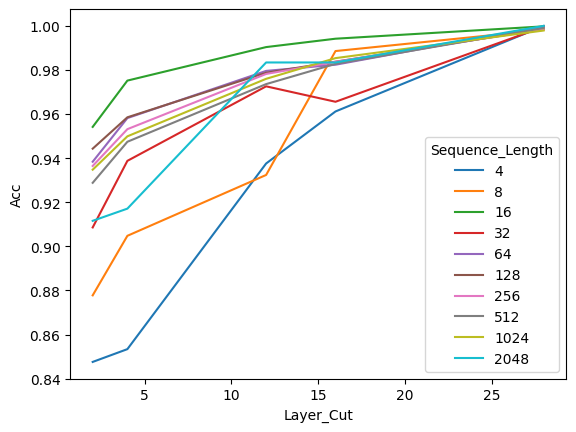

In [9]:
df_gs = df[df["Layer_Cut"] == 40]
df_compare = df[df["Layer_Cut"] != 40]

df_gs = df_gs[["ID", "Sequence_Length", "Tokens"]]
df_gs["Tokens"] = [v[0] for v in df_gs["Tokens"]]

df_compare = df_compare[["ID", "Layer_Cut", "Sequence_Length", "Tokens"]]
df_compare["Tokens"] = [v[:5] for v in df_compare["Tokens"]]

acc_check = pd.merge(df_compare, df_gs, on = ["ID", "Sequence_Length"], suffixes=["_bench", "_true"])
acc_check["Acc"] = [acc_check["Tokens_true"][i] in acc_check["Tokens_bench"][i] for i in range(acc_check.shape[0])]
acc_check["Acc"] = acc_check["Acc"].astype(int)

to_plot_acc = acc_check.drop(["Tokens_bench", "Tokens_true", "ID"], axis = 1).groupby(["Layer_Cut", "Sequence_Length"]).mean().reset_index()
to_plot_acc["Sequence_Length"] = to_plot_acc["Sequence_Length"].astype(str)

sns.lineplot(data=to_plot_acc, x="Layer_Cut", y = "Acc", hue = "Sequence_Length")

In [10]:
def common_elements(list1, list2):
    """
    Get the number of common elements between two lists.
    
    Args:
    list1: First list.
    list2: Second list.
    
    Returns:
    Number of common elements between the two lists.
    """
    set1 = set(list1)
    set2 = set(list2)
    common = set1.intersection(set2)
    return len(common)

In [1]:
df_gs = df[df["Layer_Cut"] == 40]
df_compare = df[df["Layer_Cut"] != 40]

df_gs = df_gs[["ID", "Sequence_Length", "Tokens"]]
df_gs["Tokens"] = [v[:5] for v in df_gs["Tokens"]]

df_compare = df_compare[["ID", "Layer_Cut", "Sequence_Length", "Tokens"]]
df_compare["Tokens"] = [v[:5] for v in df_compare["Tokens"]]

acc_check = pd.merge(df_compare, df_gs, on = ["ID", "Sequence_Length"], suffixes=["_bench", "_true"])
acc_check["Acc"] = [common_elements(acc_check["Tokens_true"][i], acc_check["Tokens_bench"][i]) for i in range(acc_check.shape[0])]
acc_check["Acc"] = acc_check["Acc"].astype(int)

to_plot_acc = acc_check.drop(["Tokens_bench", "Tokens_true", "ID"], axis = 1).groupby(["Layer_Cut", "Sequence_Length"]).mean().reset_index()
to_plot_acc["Sequence_Length"] = to_plot_acc["Sequence_Length"].astype(str)

sns.lineplot(data=to_plot_acc, x="Layer_Cut", y = "Acc", hue = "Sequence_Length")

NameError: name 'df' is not defined

In [12]:
import numpy as np

def cross_entropy(logits1, logits2):
    """
    Calculate the cross entropy between two lists of logits.
    
    Args:
    logits1: List of logits (raw predictions) from the first model.
    logits2: List of logits (raw predictions) from the second model.
    
    Returns:
    Cross entropy between the two sets of logits.
    """
    # Convert logits to probabilities
    probs1 = np.exp(logits1 - np.max(logits1)) / np.sum(np.exp(logits1 - np.max(logits1)))
    probs2 = np.exp(logits2 - np.max(logits2)) / np.sum(np.exp(logits2 - np.max(logits2)))
    
    # Avoiding log(0) by adding a small epsilon
    epsilon = 1e-10
    
    # Calculate cross entropy
    cross_entropy = -np.sum(probs1 * np.log(probs2 + epsilon))
    
    return cross_entropy

<Axes: xlabel='Layer_Cut', ylabel='CCE'>

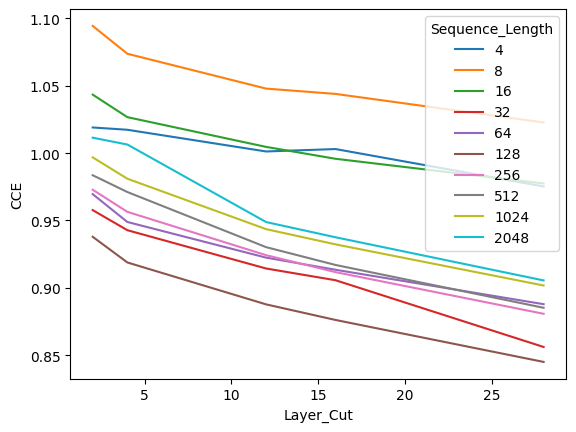

In [13]:
df_gs = df[df["Layer_Cut"] == 40]
df_compare = df[df["Layer_Cut"] != 40]

df_gs = df_gs[["ID", "Sequence_Length", "Logits"]]

df_compare = df_compare[["ID", "Layer_Cut", "Sequence_Length", "Logits"]]

acc_check = pd.merge(df_compare, df_gs, on = ["ID", "Sequence_Length"], suffixes=["_bench", "_true"])
acc_check["CCE"] = [cross_entropy(acc_check["Logits_true"][i], acc_check["Logits_bench"][i]) for i in range(acc_check.shape[0])]

to_plot_acc = acc_check.drop(["Logits_bench", "Logits_true", "ID"], axis = 1).groupby(["Layer_Cut", "Sequence_Length"]).mean().reset_index()
to_plot_acc["Sequence_Length"] = to_plot_acc["Sequence_Length"].astype(str)

sns.lineplot(data=to_plot_acc, x="Layer_Cut", y = "CCE", hue = "Sequence_Length")

<Axes: xlabel='Layer_Cut', ylabel='faster'>

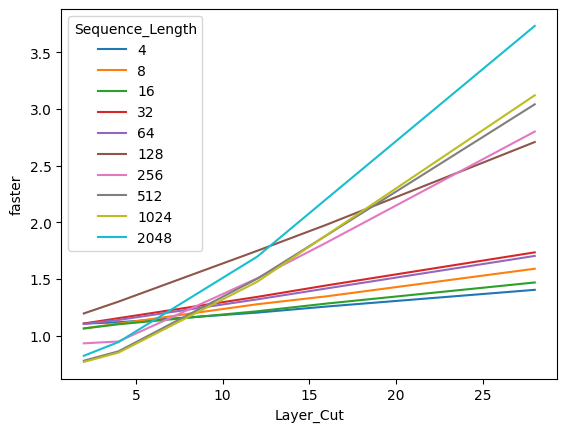

In [14]:
df_gs = df[df["Layer_Cut"] == 40]
df_compare = df[df["Layer_Cut"] != 40]

df_gs = df_gs[["ID", "Sequence_Length", "Length"]]

df_compare = df_compare[["ID", "Layer_Cut", "Sequence_Length", "Length"]]

acc_check = pd.merge(df_compare, df_gs, on = ["ID", "Sequence_Length"], suffixes=["_bench", "_true"])
acc_check["faster"] = [acc_check["Length_bench"][i]/acc_check["Length_true"][i] for i in range(acc_check.shape[0])]

to_plot_acc = acc_check.drop(["Length_bench", "Length_true", "ID"], axis = 1).groupby(["Layer_Cut", "Sequence_Length"]).mean().reset_index()
to_plot_acc["Sequence_Length"] = to_plot_acc["Sequence_Length"].astype(str)

sns.lineplot(data=to_plot_acc, x="Layer_Cut", y = "faster", hue = "Sequence_Length")